## Stock Sentiment Analysis

In [90]:
!pip install wordcloud
!pip install gensim
!pip install nltk
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install tensorflow
!pip install jupyterthemes
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates from a subpr

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# TENSORFLOW
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [92]:
from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False)

### STEP 2: LOADING THE STOCKS DATA

In [93]:
stock_df = pd.read_csv('stock_sentiment.csv')


In [94]:
# VIEWING THE DATA
stock_df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [95]:
# DATAFRAME INFORMATION:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [96]:
# CHECKING FOR NULL VALUES
stock_df.isnull().sum()

Text         0
Sentiment    0
dtype: int64

In [97]:
# CONFIRMING THE ELEMENTS PRESENT IN Sentiment Column
stock_df['Sentiment'].unique()

array([1, 0], dtype=int64)

<Axes: ylabel='count'>

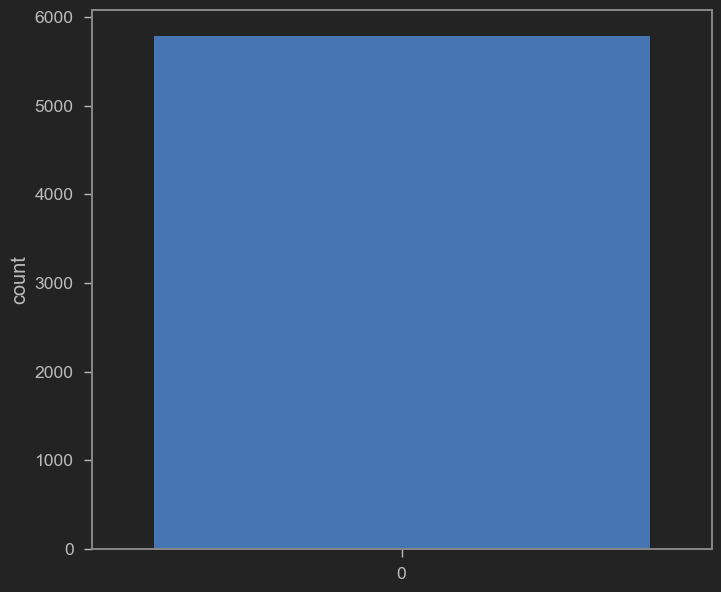

In [98]:
# VISUALIZING OUR DATASET
sns.countplot(stock_df['Sentiment'])

### STEP 3: PERFORMING DATA CLEANING

#### A) REMOVING PUNCTUATIONS FROM TEXT

In [99]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [100]:
# DEFINING A FUNCTION TO REMOVE PUNCTUATIONS
def remove_func(message):
    Test_punc_removed = [char for char in message if char not in string .punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    
    return Test_punc_removed_join

In [101]:
# REMOVING PUNCTUATIONS FROM OUR DATASET
stock_df['Text-Without-Punctuations'] = stock_df['Text'].apply(remove_func)

stock_df

,Text,Sentiment,Text-Without-Punctuations
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...
3,MNTA Over 12.00,1,MNTA Over 1200
4,OI Over 21.37,1,OI Over 2137
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...


#### B) REMOVING STOPWORDS

In [102]:
# DOWNLOADING STOPWORDS
nltk.download("stopwords")
stopwords.words('english')

[nltk_data] Downloading package stopwords to C:\Users\devarsh
[nltk_data]     patel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [103]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# AFTER LOOKING AT THE DATA, IT WAS OBSERVED THAT SOME WORDS WERE FREQUENTLY REPEATED, THUS ADDING THEM IN THE STOPWORDS LIST (TO BE REMOVED FROM THE DATASET)
stop_words.extend(['from', 'subject', 'https', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year'])

# DEFINING A FUNCTION TO REMOVE STOP WORDS AND SOME SHORT WORDS TOO (LESS THAN 3 CHARACTERS LONG), SINCE THEY DONT GIVE VALUE TO THE DATA

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) >=3 and token not in stop_words:
            result.append(token)
    return result

In [104]:
# APPLYING THE PREPROCESSING FUNCTION:
stock_df['Text_Pre-processed'] = stock_df['Text-Without-Punctuations'].apply(preprocess)
stock_df

,Text,Sentiment,Text-Without-Punctuations,Text_Pre-processed
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,..."
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw..."
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[afraid, short, amzn, looking, like, nearmonop..."
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta]
4,OI Over 21.37,1,OI Over 2137,[]
...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s..."
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, investors, book, profits,..."
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri..."
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift..."


### STEP 4: PLOTTING WORDCLOUD

In [105]:
# JOINING THE PREPROCESSED TEXT INTO A STRING
stock_df['Text_Pre-processed-joined'] = stock_df['Text_Pre-processed'].apply(lambda x: " ".join(x))
stock_df

,Text,Sentiment,Text-Without-Punctuations,Text_Pre-processed,Text_Pre-processed-joined
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,...",kickers watchlist xide tit soq pnk cpw bpz tra...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw...",movie return feageed indicator trades awesome
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[afraid, short, amzn, looking, like, nearmonop...",afraid short amzn looking like nearmonopoly eb...
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta],mnta
4,OI Over 21.37,1,OI Over 2137,[],
...,...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s...",industry body cii said discoms likely suffer n...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, investors, book, profits,...",gold prices slip investors book profits amid c...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri...",workers bajaj auto agreed wage cut period apri...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift...",sharemarket live sensex high points nifty test...


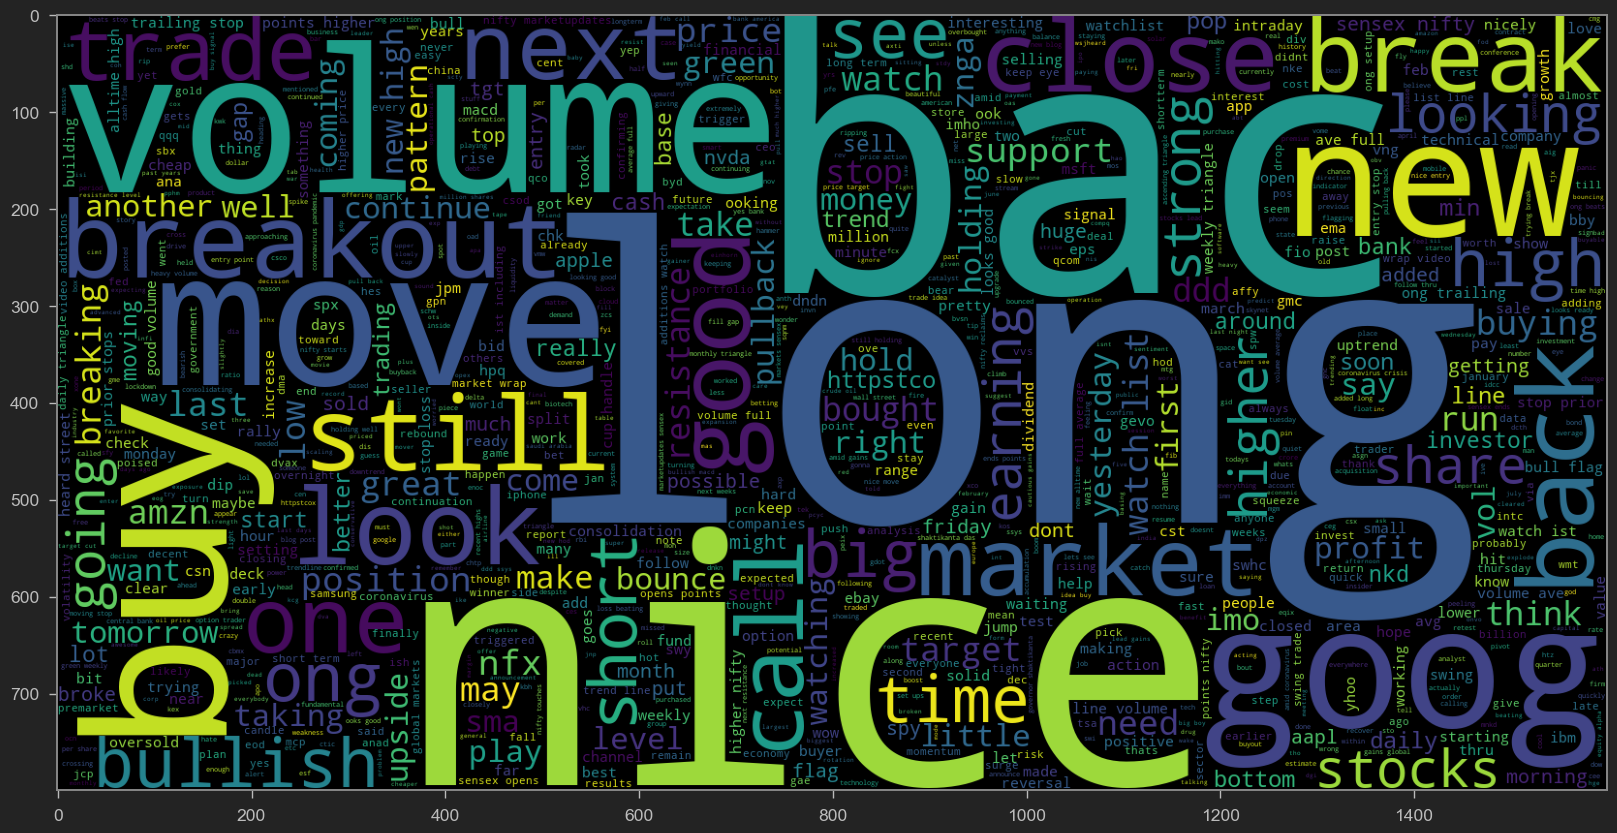

In [106]:
# PLOTTING A WORDCLOUD:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 1000, width = 1600, height = 800).generate(" ".join(stock_df[stock_df['Sentiment']==1]['Text_Pre-processed-joined']))
plt.imshow(wc)

### STEP 5: VISUALIZING CLEANED DATASET

In [107]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\devarsh
[nltk_data]     patel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [108]:
# TOKENIZING THE TEXT INTO WORDS

tweets_length = [ len(nltk.word_tokenize(x)) for x in stock_df['Text_Pre-processed-joined'] ]
tweets_length

[14,
 6,
 7,
 1,
 0,
 1,
 8,
 13,
 8,
 4,
 10,
 18,
 8,
 8,
 11,
 5,
 12,
 10,
 12,
 4,
 6,
 5,
 2,
 5,
 3,
 10,
 3,
 3,
 9,
 6,
 8,
 10,
 8,
 3,
 10,
 11,
 4,
 8,
 11,
 10,
 10,
 7,
 9,
 8,
 4,
 10,
 8,
 7,
 7,
 9,
 10,
 10,
 8,
 2,
 14,
 12,
 9,
 8,
 1,
 14,
 7,
 11,
 5,
 13,
 6,
 6,
 7,
 6,
 6,
 10,
 9,
 4,
 10,
 13,
 16,
 6,
 9,
 6,
 2,
 11,
 5,
 4,
 9,
 11,
 16,
 4,
 9,
 5,
 6,
 2,
 1,
 5,
 9,
 4,
 7,
 6,
 7,
 10,
 1,
 3,
 9,
 4,
 16,
 8,
 10,
 11,
 18,
 6,
 7,
 13,
 12,
 9,
 3,
 3,
 10,
 10,
 8,
 6,
 8,
 5,
 5,
 8,
 9,
 15,
 3,
 5,
 9,
 18,
 13,
 11,
 3,
 1,
 1,
 2,
 7,
 12,
 12,
 8,
 8,
 10,
 9,
 10,
 15,
 8,
 9,
 9,
 12,
 10,
 6,
 10,
 13,
 4,
 11,
 8,
 15,
 13,
 8,
 12,
 5,
 5,
 3,
 7,
 2,
 4,
 10,
 5,
 6,
 10,
 6,
 16,
 9,
 6,
 5,
 10,
 9,
 10,
 8,
 2,
 10,
 9,
 10,
 12,
 7,
 10,
 7,
 3,
 6,
 5,
 9,
 9,
 4,
 6,
 5,
 4,
 4,
 8,
 10,
 8,
 8,
 13,
 9,
 7,
 10,
 12,
 8,
 6,
 5,
 3,
 10,
 11,
 6,
 9,
 10,
 13,
 10,
 7,
 12,
 7,
 11,
 10,
 4,
 4,
 3,
 10,
 2,
 9,
 10,
 15,
 12,
 10

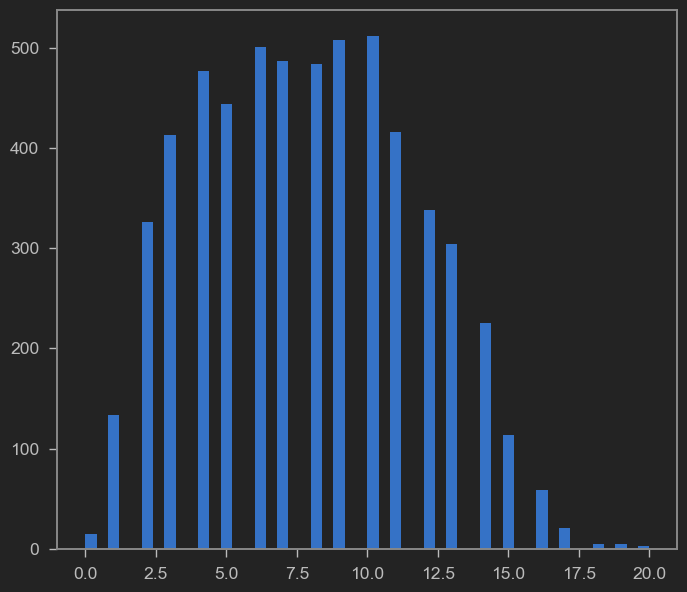

In [109]:
# CREATING A HISTOGRAM TO VISUALIZE THE TOKENIZED DATA:
plt.figure()
plt.hist(tweets_length, bins =50)
plt.show()

In [110]:
# THUS WE CAN OBSERVE THAT MOST OF OUR TWEETS EXIST BETWEEN 5 - 10 WORDS (THE HISTOGRAM RESEMBLES A BELL-CURVE)

### STEP 6: PREPARING THE DATA BY TOKENIZING AND PADDING

In [111]:
# A) TOKENIZING WORKS BY CONVERTING EACH TEXT INTO A SEQUENCE OF INTEGERS

In [112]:
# OBTAINING THE TOTAL NUMBER OF UNIQUE WORDS IN OUR DATASET:

list_of_words = []

for i in stock_df['Text_Pre-processed']:
    for j in i:
        list_of_words.append(j)
        
total_words  = len(set(list_of_words))
total_words

9268

In [113]:
# SPLITTING DATA INTO TRAIN AND TEST
X = stock_df['Text_Pre-processed']
y = stock_df['Sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [114]:
X_train.shape

(4632,)

In [115]:
X_test.shape

(1159,)

In [116]:
X_train

2268                                                [ocn]
3547    [nfx, daily, make, green, dot, buy, yesterday,...
2987           [playing, nicely, last, weeks, video, spy]
5112    [cuts, oil, output, prevent, even, worse, coll...
1667    [net, income, million, operational, cash, flow...
                              ...                        
58                                                 [gave]
5154    [morgan, stanley, ceo, james, gorman, senior, ...
2605    [ebay, nice, consolidation, since, break, earn...
2372                               [continuation, likely]
1813    [come, far, gap, fill, fits, eiffel, tower, an...
Name: Text_Pre-processed, Length: 4632, dtype: object

In [117]:
# CREATING A TOKENIZER TO TOKENIZE THE WORDS AND CREATE A SEQUENCE OF TOKENIZED WORDS (THAT CAN BE INTERPRETTED BY OUR MACHINE LEARNING ALGORITHM)
tokenizer = Tokenizer(num_words = total_words)

tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [118]:
train_sequences

[[767],
 [45, 73, 102, 42, 883, 13, 93, 43, 487, 405, 9, 256],
 [1736, 301, 54, 217, 185, 61],
 [527, 119, 768, 3379, 158, 616, 1737, 571, 111, 454, 3380, 3381],
 [488, 769, 112, 281, 60, 231, 112, 1738, 3382, 1738, 15, 282],
 [1739, 143, 1740, 1741, 1742, 1743, 149, 1406, 3383, 44, 3384, 3385],
 [122, 489, 218],
 [770, 34, 1011],
 [19, 771, 35, 56, 884, 138, 94, 47],
 [3386, 3387, 2276, 3388, 2277],
 [1172, 31, 67, 71, 29, 1407, 15],
 [32, 528, 13, 22, 43, 334],
 [64, 572, 1744, 1173, 205, 2278, 1408, 2279, 2280, 1174, 885, 455, 2281],
 [42, 25, 21, 3389],
 [120, 770],
 [3390, 573, 3391, 1175, 3392, 113, 529],
 [1745, 11, 37, 85, 13, 174, 186],
 [6, 196, 426, 36, 41, 1746, 31],
 [1747, 1409, 103, 187, 197, 1176, 67, 244, 159, 316, 65, 1410, 3393],
 [3, 3394, 316, 168, 3395, 1411],
 [6, 456, 99, 61, 12, 457, 1412],
 [266, 574, 198, 1413],
 [3, 74, 1748, 687, 11, 91, 383, 2282, 283, 384],
 [175, 688, 55, 384],
 [2283, 2284],
 [1012, 3396, 490, 406, 491, 68, 1749, 772, 16, 530],
 [358, 1

In [119]:
# B) PADDING THE TRAINING AND TESTING DATA
# BASICALLY MAKING ALL OF THE DIGITS IN OUR TRAIN AND TEST DATA TO EQUAL LENGTH IN ORDER TO MAKE THE DEEP LEARNING MODEL MORE EFFICIENT (WE ADD ZERO'S IN THE START OF DIGITS TO MAKE THEM OF EQUAL LENGTH)
padded_train = pad_sequences(train_sequences, maxlen=15, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen=15, padding = 'post', truncating = 'post')


In [120]:
# CONVERTING DATA INTO CATEGORICAL 2D REPRESENTATIONS:
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

y_train_cat.shape
y_test_cat.shape

(1159, 2)

In [121]:
y_test_cat

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [122]:
# THE IDEA OF CONVERTING Y_TRAIN AND y_test to categorical 2D REPRESENTATION IS TO MAKE SURE THAT THE OUTPUT WOULD HAVE TWO NEURONS
# THIS IS BECAUSE BASICALLY WE HAVE 2 CLASSES I.E. 0, AND 1
# SO, IF NEURON 1 WERE TO FIRE, WE'LL GET THE OUTPUT AS 1 AND 0; IF NEURON 2 WEERE TO FIRE, WE'LL GET THE OUTPUT AS 0 AND 1

### STEP 7: BUILDING A CUSTOM-BAASED DEEP NEURAL NETWORK TO PERFORM SENTIMENT ANALYSIS

In [123]:
model = Sequential()

model.add(Embedding(total_words, output_dim = 512))  # ADDING EMBEDDING LAYER

# BI-DIRECTIONAL RNN AND LSTM
model.add(LSTM(256))

model.add(Dense(128, activation = 'relu')) # ADDING A DENSE LAYER WITH 2 NEURONS AND ACTIVATION FUNCTION AS 'RELU'
model.add(Dropout(0.3)) # REGULARIZATION PARAMETER (TO PREVENT OVERFITTING)

model.add(Dense(2, activation = 'softmax')) # ADDING DENSE LAYER WITH 2 NEURONS AND ACTIVATION FUNCTION AS 'SOFTMAX'
model.compile(optimizer =  'adam', loss = 'binary_crossentropy', metrics = ['acc']) # COMPILING THE MODEL WITH OPTIMIZER - 'ADAM' AND WE WILL BE USING LOSS AS: 'BINARY_CROSSENTROPY' SINCE WE HAVE ONLY 2 CATEGORICAL VARIABLES I.E 0, AND 1 
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [124]:
# TRAINING THE MODEL: 
model.fit(padded_train, y_train_cat, batch_size =32, validation_split=0.2, epochs = 3)

Epoch 1/3
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - acc: 0.6630 - loss: 0.6325 - val_acc: 0.7314 - val_loss: 0.5555
Epoch 2/3
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - acc: 0.8637 - loss: 0.3487 - val_acc: 0.7745 - val_loss: 0.5458
Epoch 3/3
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - acc: 0.9318 - loss: 0.1814 - val_acc: 0.7735 - val_loss: 0.6534


In [125]:
# THUS WE ACHIEVED AN ACCURACY OF 94.82% AND VALIDATION-ACCURACY AS 77.13%

### STEP 8: ASSESING THE TRAINING MODEL PERFORMANCE

In [126]:
pred = model.predict(padded_test)

prediction  = []
for i in pred:
    prediction.append(np.argmax(i))
    
prediction

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


[1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,


In [127]:
original = []
for i in y_test_cat:
    original.append(np.argmax(i))
    
original

[1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,


In [128]:
# CALCULATING ACCURACY SCORE FOR UNSEEN DATA (TEST DATA)
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, f1_score

accuracy = accuracy_score(original, prediction)
accuracy

0.7618636755823986

In [129]:
f1 = f1_score(original, prediction)
precision = precision_score(original, prediction)
recall = recall_score(original, prediction)
auc = roc_auc_score(original, prediction)

print("f1 for the model is: {}".format(f1))
print("Precision for the model is: {}".format(precision))
print("Recall for the model is: {}".format(recall))
print("AUC for the model is: {}".format(auc))

f1 for the model is: 0.8155080213903744
Precision for the model is: 0.8133333333333334
Recall for the model is: 0.8176943699731903
AUC for the model is: 0.7393556595628663


<Axes: >

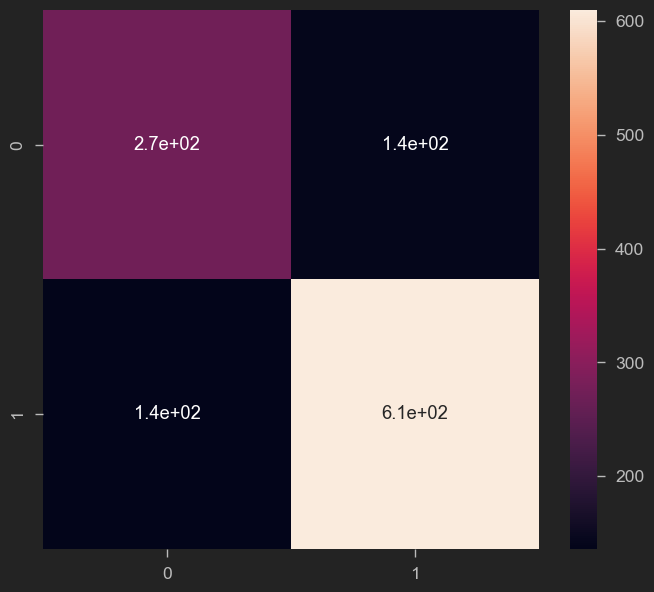

In [130]:
cm = confusion_matrix(original, prediction)

sns.heatmap(cm, annot = True)